<a href="https://colab.research.google.com/github/DrHB/PyTorch-Course/blob/main/Intro-PyTorch-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch Part 2

> by Habib Bukhari and Roman Vaxenburg

In [1]:
#hide
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import animation, rc
import pandas as pd
import seaborn as sbn
!pip install fastdot -q
from fastdot import *
rc('animation', html='jshtml')
%matplotlib inline

     |████████████████████████████████| 61kB 4.7MB/s 


In this notebook we will solve the digit classification task with 3 different models of progressively increasing complexity:

* Linear classifier (logistic regression)
* Multilayer perceptron (non-linear fully connected network)
* Convolutional neural network

# Classifying digits

We've just implemented a simple regression model. Now let's solve a simple digit classification task! We will use a dataset of images of hand-written digits from 0 to 9 and the classifier will predict the digit from the image.


<div class="alert alert-block alert-info">
The <b>MNIST</b> database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.
</div>

We will use a simple linear layer `nn.Linear` again.

## Explore the data

Load the dataset of digit images and split the data into training and validation subsets.

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)
mnist_validset = datasets.MNIST(root='./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
mnist_validset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [5]:
img, label  = mnist_trainset[0] #getting 0th element of dataset

In [6]:
type(img), type(label)

(PIL.Image.Image, int)

In [7]:
label

5

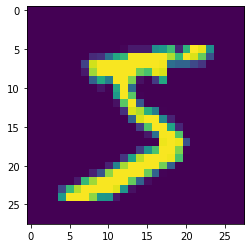

In [8]:
plt.imshow(img) #we can use matplotlib function imshow to display image

In [9]:
def show_image(x, title: str):
    #function that shows image with a title
    plt.imshow(x)
    plt.title(f'Label: {title}')

In [10]:
img, label = mnist_trainset[5438]

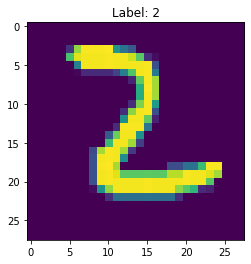

In [11]:
show_image(img, label)

Each pixel in the image has value between 0 and 255
<div class="alert alert-block alert-info">
The word “pixel” means a picture element. Every photograph, in digital form, is made up of pixels. They are the smallest unit of information that makes up a picture. Usually round or square, they are typically arranged in a 2-dimensional grid.
</div>

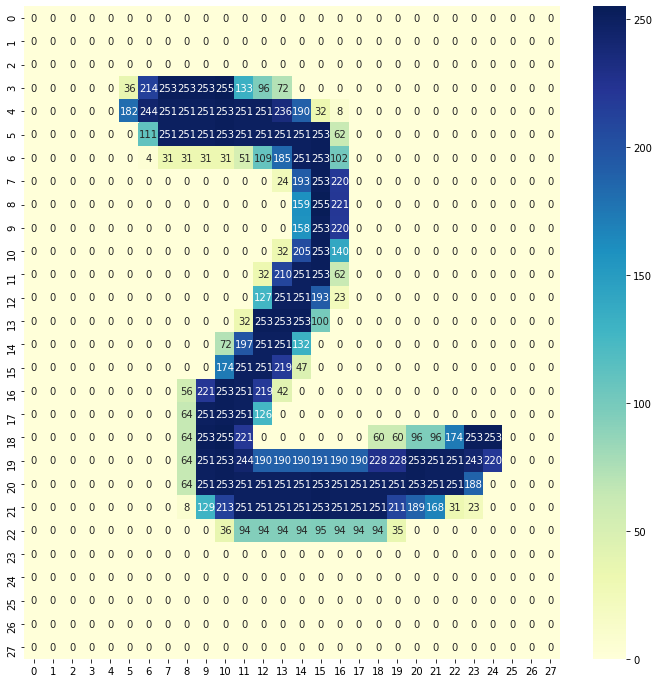

In [12]:
#this is image which has value from 0 to 255 
image_array=np.array(img)
fig, axes = plt.subplots(figsize=(12, 12))
sbn.heatmap(image_array, annot=True, fmt="d", cmap="YlGnBu")

In [13]:
 # dividing by 255 to scale everything between 0 to 1 (gettng rid of large numbers)
def convert_to_tensor(x):
    x= torch.tensor(np.array(x).astype('float'))
    x= x /255
    return x

In [14]:
img, label = mnist_trainset[223]

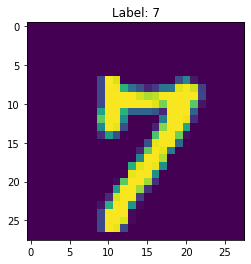

In [15]:
show_image(img, label)

In [16]:
img_tensor = convert_to_tensor(img)
type(img), type(img_tensor)

(PIL.Image.Image, torch.Tensor)

In [17]:
img_tensor.shape

torch.Size([28, 28])

Luckily, pytorch provides us with this transformation so we don't have to convert the data to `tensor` manually 

In [18]:
transform=transforms.Compose([
        transforms.ToTensor(),
        ])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_validset = datasets.MNIST(root='./data', train=False, download=True,transform=transform)

## Dataloader
<div class="alert alert-block alert-info">
PyTorch offers a solution for parallelizing the data loading process with the support of automatic batching as well. This is the DataLoader class present within the torch.utils.
    data package. <br>
 <b> Batch size </b>is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. <br>
 <b> Shuffle </b> Whether you want the data to be reshuffled or not. <br>
 <b> num_workers </b> Number of sub-processes needed for loading the data. <br>
 </div>

In [19]:
batch_size = 64
train_dl = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(mnist_validset, batch_size=batch_size, shuffle=True, num_workers=0)

In [20]:
train_dl

In [21]:
batch_x, batch_y = next(iter(valid_dl)) # get one batch from the validation dataset

Notice the dimensions of `x` and `y`

In [22]:
print(batch_x.shape)
print(batch_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


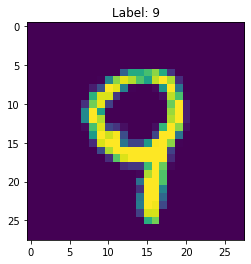

In [23]:
show_image(batch_x[0][0], str(batch_y[0].item()))

# Model 1: Linear Model

The linear model will take input images consisting of $28\times 28 = 784$ pixels and will output class prediction between 0 and 9.

The (sinlge) linear layer of the model will consist of 10 neurons, one per class. As input, each neuron will receive a weighted sum of the 794 pixel intensities.

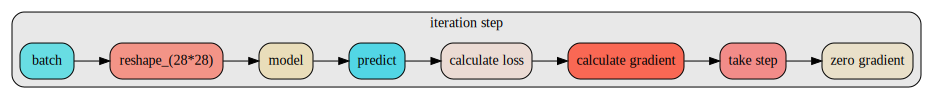

In [24]:
#hide
layers = ['batch','reshape_(28*28)', 'model', 'predict', 'calculate loss', 'calculate gradient', 'take step', 'zero gradient']
block  = 'iteration step'
g = graph_items(seq_cluster(layers, block))
g

In [25]:
input_size = 28 * 28 # 784, number of pixels in image
num_classes = 10 # 10 classes of images
model = nn.Linear(in_features=input_size, out_features=num_classes)

In [26]:
model # print summary of the model

Linear(in_features=784, out_features=10, bias=True)

In [27]:
model.weight

Parameter containing:
tensor([[-0.0125,  0.0151, -0.0070,  ..., -0.0059,  0.0028,  0.0045],
        [ 0.0284, -0.0178,  0.0164,  ..., -0.0314,  0.0072, -0.0340],
        [-0.0172,  0.0188,  0.0020,  ...,  0.0168, -0.0101,  0.0242],
        ...,
        [ 0.0285,  0.0230, -0.0212,  ...,  0.0326, -0.0331, -0.0312],
        [-0.0233, -0.0053, -0.0305,  ..., -0.0031, -0.0340, -0.0255],
        [ 0.0180, -0.0112, -0.0181,  ...,  0.0268, -0.0290,  0.0108]],
       requires_grad=True)

Every neuron sees a weighted sum of all 784 pixels, so the number of weights per neuron in our linear layer is 784

In [28]:
model.weight.shape # (number of neurons, number of pixels)

torch.Size([10, 784])

In [29]:
model.bias.shape # (number of neurons (or classes))

torch.Size([10])

In [30]:
model.eval() # switch to evaluation mode

Linear(in_features=784, out_features=10, bias=True)

In [31]:
batch_x, batch_y = next(iter(valid_dl)) # get one batch from the validation dataset

In [32]:
print(batch_x.shape)
print(batch_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's try passing data batch to the model (..will throw an error becaue the data is of wrong shape)

In [33]:
with torch.no_grad():
    y_hat = model(batch_x)

RuntimeError: ignored

In [34]:
batch_x = batch_x.view(-1, 28*28) # -1 means infer this dimension automatically
batch_x.shape # (batch, number of pixels)

torch.Size([64, 784])

Now we can feed data to the model safely

In [35]:
# forward pass
y_hat = model(batch_x)

In [36]:
# prediction (batch, number of classes)
y_hat.shape

torch.Size([64, 10])

In [37]:
batch_x.shape # (batch, number of pixels)

torch.Size([64, 784])

In [38]:
#print y_hat for 1 image ten probabilities

## Loss

To calculate the loss, we will use the cross-entropy loss, $L = -\sum_i y_i \log  \hat{y}_i$, where the sum is over the batch.

This loss is typically used in classification problems. 

Note that the output of our model and the ground true labels are not probabilities yet. The `nn.CrossEntropyLoss` class will transform them to probabilities internally by applying `nn.LogSoftmax()` to them.

In [39]:
loss_fn = nn.CrossEntropyLoss()

In [40]:
loss = loss_fn(y_hat, batch_y)

In [41]:
loss

tensor(2.3213, grad_fn=<NllLossBackward>)

In [42]:
# calculate the gradient in backward pass
loss.backward()

Let's put everything together (and also initialize the optimizer)

In [43]:
input_size = 28 * 28 # 784
num_classes = 10

num_epochs = 5
batch_size = 100
learning_rate = 0.01

# Logistic regression model
model = nn.Linear(in_features=input_size, out_features=num_classes, bias=True)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss() # applies softmax internally
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<div class="alert alert-block alert-info">
<b> Epoch </b>  is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. <br>
<b> Iterations </b> is the number of batches needed to complete one epoch.<br>
    
Let’s say we have <b>5000</b> training examples that we are going to use. We can divide the dataset of <b>5000</b> examples into batches of <b>500</b> then it will take <b>10 iterations</b> to complete <b>1 epoch</b>
</div>



# Train the model

We are ready to train the model!

In [44]:
losses = [] # here we will collect the loss history
n_steps = len(train_dl) # number of iterations in one epoch

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl): # iterate over training data
        
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        
        # Parameter update
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, n_steps, loss.item()))


Epoch [1/5], Step [100/938], Loss: 1.5547
Epoch [1/5], Step [200/938], Loss: 1.1599
Epoch [1/5], Step [300/938], Loss: 0.9830
Epoch [1/5], Step [400/938], Loss: 0.8643
Epoch [1/5], Step [500/938], Loss: 0.7064
Epoch [1/5], Step [600/938], Loss: 0.7500
Epoch [1/5], Step [700/938], Loss: 0.8160
Epoch [1/5], Step [800/938], Loss: 0.5611
Epoch [1/5], Step [900/938], Loss: 0.6655
Epoch [2/5], Step [100/938], Loss: 0.6611
Epoch [2/5], Step [200/938], Loss: 0.6147
Epoch [2/5], Step [300/938], Loss: 0.4281
Epoch [2/5], Step [400/938], Loss: 0.4399
Epoch [2/5], Step [500/938], Loss: 0.5489
Epoch [2/5], Step [600/938], Loss: 0.5031
Epoch [2/5], Step [700/938], Loss: 0.5657
Epoch [2/5], Step [800/938], Loss: 0.5451
Epoch [2/5], Step [900/938], Loss: 0.4952
Epoch [3/5], Step [100/938], Loss: 0.4693
Epoch [3/5], Step [200/938], Loss: 0.4322
Epoch [3/5], Step [300/938], Loss: 0.4690
Epoch [3/5], Step [400/938], Loss: 0.4093
Epoch [3/5], Step [500/938], Loss: 0.4695
Epoch [3/5], Step [600/938], Loss:

# Test the model

Let's test the model on the validation part of the dataset.

In test phase, we don't need to compute gradients (for memory and time efficiency).

Let's use the `no_grad()` context.

In [45]:
with torch.no_grad():
    
    correct = 0.
    total = 0
    
    for images, labels in valid_dl: # iterate over validation data
        
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)
        
        # Forward pass
        outputs = model(images)
        
        # Out of 10 output values per image, let's pick the largest one as the most probable class
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0) # total number of data examples
        correct += (predicted == labels).sum() # correct predictions

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 90.0 %


Not a bad accuracy for such a simple model!

Text(0, 0.5, 'Classification training loss')

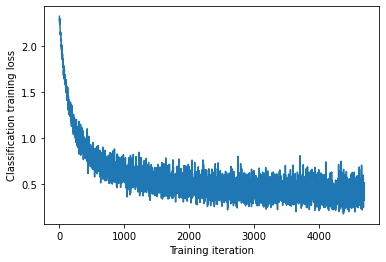

In [46]:
plt.plot(losses)
plt.xlabel('Training iteration')
plt.ylabel('Classification training loss')

Let's get some actual predictions

In [47]:
images, labels = next(iter(valid_dl)) # get one batch from validation dataset

with torch.no_grad():
    
    # Reshape images to (batch_size, input_size)
    images = images.reshape(-1, input_size)
    
    # Forward pass
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

Predicted classes for the batch

In [48]:
predicted

tensor([4, 5, 9, 2, 6, 9, 6, 5, 3, 9, 1, 7, 3, 8, 9, 0, 1, 0, 3, 8, 0, 2, 2, 7,
        9, 0, 1, 9, 1, 5, 8, 9, 3, 1, 9, 5, 6, 3, 0, 3, 9, 1, 5, 9, 1, 4, 1, 0,
        9, 9, 0, 5, 1, 3, 2, 0, 5, 4, 1, 6, 8, 4, 0, 2])

True classes for the batch

In [49]:
labels

tensor([2, 3, 9, 2, 6, 9, 6, 8, 3, 9, 1, 7, 3, 8, 9, 0, 1, 6, 3, 5, 0, 2, 2, 7,
        4, 0, 1, 9, 5, 5, 5, 9, 3, 1, 9, 5, 6, 3, 0, 3, 9, 1, 5, 9, 1, 4, 1, 0,
        9, 9, 0, 5, 1, 3, 2, 0, 5, 4, 1, 6, 8, 4, 0, 2])

In [50]:
predicted == labels

tensor([False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

Let's plot the images in the batch. First we'll have to convert them back to 28x28 square shape.

In [55]:
images.shape # (batch, pixels)

torch.Size([64, 28, 28])

In [56]:
#convert back to square 
images = images.reshape(-1, 28, 28)
images.shape # (batch, 28, 28)

torch.Size([64, 28, 28])

In [57]:
def evaluate(index):
    show_image(images[index], title=f'True :{labels[index]} / Predicted:{predicted[index]}')
    plt.pause(0.1)

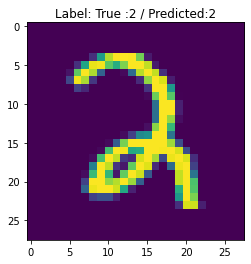

In [58]:
evaluate(index=3)

Find misclassifications in the batch

In [59]:
model_errors = (labels != predicted).nonzero(); 
model_errors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  """Entry point for launching an IPython kernel.


tensor([[ 0],
        [ 1],
        [ 7],
        [17],
        [19],
        [24],
        [28],
        [30]])

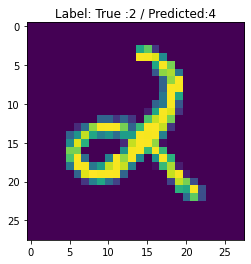

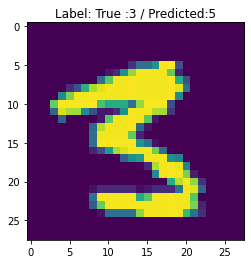

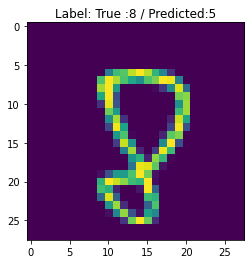

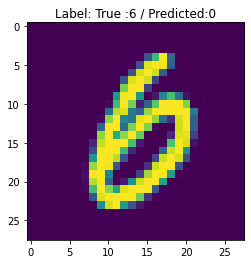

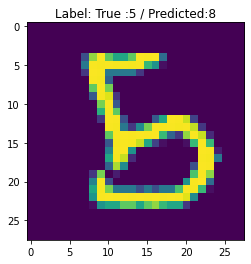

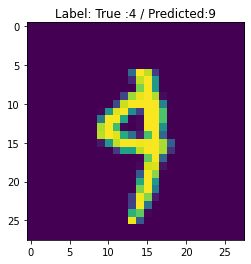

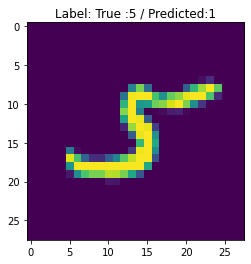

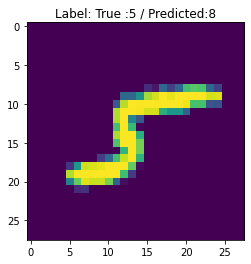

In [60]:
for i in model_errors:
    evaluate(i.item())

In [61]:
#add second max of all mmistakes

# Model 2: Multilayer Perceptron

### Combining layers and adding non-linearlity
<div class="alert alert-block alert-info">
So far we have been using the linear relation $y = mx + b$ (and linear layers). If we just make a neural network by combining such linear layers, we will keep getting linear combinations of equations and the function obtained would still be a polynomial of degree 1. <br>

To be able to model more complex non-linear relations between inputs and outputs, we'll introduce non-linear activation functions applied to the output of the linear relations we've seen before. In part, this is similar to how real neurons get activated in the brain. <br>

This helps model non-linearities and create complex non-linear functions which are not possible to modeled using only polynomial functions of low order. Without the activation, the output value $y$ is unrestricted and can range from $-\infty$ to $+\infty$. The activation functions help us restrict the output value of a neuron so that it can be decided whether it will get activated (will fire) or not. Once this non-linearity is added, the result is sent as an input to the next layer (if there is any) in the network. <br>
</div>

Pytorch contains many different activation functions, such as `nn.ReLU`, `nn.Sigmoid`, `nn.Tanh`, `nn.Softplus` and many more

https://adityashrm21.github.io/Why-Rectified-Linear-Units-Work/


https://playground.tensorflow.org/

## Model class

### Let's solve the same digit classification task with a multi-layer non-linear model.

As our model is getting more complicated, we will combine its building blocks in a separate class. 

The model will consist of three subsequent `nn.Linear` layers.

The class will also contain the `forward` method to perform forward pass where we will apply the `relu` non-linearity to the outputs of the first two linear layers.

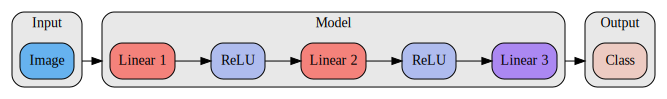

In [62]:
blocks  = ['Input', 'Model', 'Output']
layers = [['Image'], ['Linear 1','ReLU', 'Linear 2', 'ReLU', 'Linear 3'], ['Class']]
conns = ((blocks[0], blocks[1]),
         (blocks[1], blocks[2]),
        )
g = graph_items(seq_cluster(layers[0], blocks[0]),
                seq_cluster(layers[1], blocks[1]),
                seq_cluster(layers[2], blocks[2]),
               )
g.add_items(*object_connections(conns))
g

In [63]:
class MLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=250)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(in_features=250, out_features=100)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(in_features=100, out_features=10)
    
    def forward(self, x):
        # reshaping inside 
        x = x.view(-1, 28 * 28)
        x = self.act1(self.linear1(x))
        x = self.act2(self.linear2(x))
        x = self.linear3(x)
        return x

Let's initialize the model, the loss function, and the optimizer

In [64]:
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.11

model = MLP() # instance of our custom class

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss() # computes softmax internally
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Print model configuration

In [65]:
model

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (act2): ReLU()
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

In [66]:
len(list(model.parameters())) # 6 groups of parameters, 2 groups per layer

6

In [67]:
for name, param in model.named_parameters():
    print(name, param.shape)

linear1.weight torch.Size([250, 784])
linear1.bias torch.Size([250])
linear2.weight torch.Size([100, 250])
linear2.bias torch.Size([100])
linear3.weight torch.Size([10, 100])
linear3.bias torch.Size([10])


## Train the model

In [68]:
def train_fit(model, loss_fn, train_dl, num_epoch, optimizer):
    
    losses = [] # here we will collect the loss history
    n_steps = len(train_dl)
    
    model.train() # switch to training mode
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_dl):        
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, n_steps, loss.item()))
    return model, losses


In [69]:
def valid_fit(model, valid_dl):
    
    model.eval() # switch to evaluation mode
    
    with torch.no_grad():
        correct = 0.
        total = 0
        for images, labels in valid_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

        print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [70]:
model, losses = train_fit(model, loss_fn, train_dl, num_epochs, optimizer)

Epoch [1/5], Step [100/938], Loss: 0.6708
Epoch [1/5], Step [200/938], Loss: 0.6108
Epoch [1/5], Step [300/938], Loss: 0.5018
Epoch [1/5], Step [400/938], Loss: 0.3672
Epoch [1/5], Step [500/938], Loss: 0.4122
Epoch [1/5], Step [600/938], Loss: 0.2357
Epoch [1/5], Step [700/938], Loss: 0.1657
Epoch [1/5], Step [800/938], Loss: 0.2795
Epoch [1/5], Step [900/938], Loss: 0.2370
Epoch [2/5], Step [100/938], Loss: 0.1787
Epoch [2/5], Step [200/938], Loss: 0.1819
Epoch [2/5], Step [300/938], Loss: 0.1413
Epoch [2/5], Step [400/938], Loss: 0.1611
Epoch [2/5], Step [500/938], Loss: 0.2296
Epoch [2/5], Step [600/938], Loss: 0.1380
Epoch [2/5], Step [700/938], Loss: 0.1945
Epoch [2/5], Step [800/938], Loss: 0.0369
Epoch [2/5], Step [900/938], Loss: 0.0952
Epoch [3/5], Step [100/938], Loss: 0.0354
Epoch [3/5], Step [200/938], Loss: 0.1137
Epoch [3/5], Step [300/938], Loss: 0.1031
Epoch [3/5], Step [400/938], Loss: 0.2890
Epoch [3/5], Step [500/938], Loss: 0.0403
Epoch [3/5], Step [600/938], Loss:

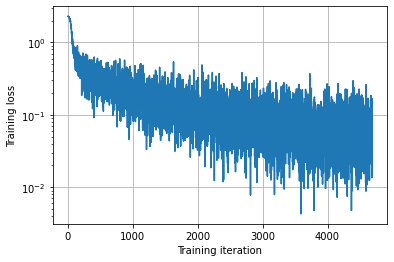

In [71]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.grid()

In [72]:
valid_fit(model, valid_dl)

Accuracy of the model on the 10000 test images: 97.3499984741211 %


Great!

Now let's get some predictions

In [73]:
images, labels = next(iter(valid_dl))
with torch.no_grad():
    images = images.reshape(-1, input_size)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

In [74]:
images = images.reshape(-1, 28, 28)
images.shape

torch.Size([64, 28, 28])

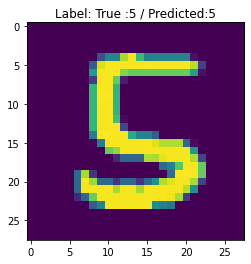

In [75]:
evaluate(index=2)

# Model 3: Convolutional Neural Network (CNN)
<div class="alert alert-block alert-info">
<b>CNN</b> is a major improvement upon the simple (fully connected) multilayer perceptron for tasks where local information is important, and where translational invariance can be expected. Our image classification task is just like this! <br>
</div>


https://setosa.io/ev/image-kernels/

https://towardsdatascience.com/history-of-convolutional-blocks-in-simple-code-96a7ddceac0c

<div class="alert alert-block alert-info">
Our model will be constructed as a separate class <b>CNNModel</b>. It will contain three convolutional blocks followed by a <b>nn.Linear</b> layer. Conceptually, this architecture can be thought of as a convolutional feature extractor (the three convolutional blocks) followed by a simple linear classifier (the linear layer), just like the one we've used before. Each convolution block is also a separate class <b>ConvBlock</b>. It contains a convolutional <b>nn.Conv2d</b> layer, followed by a non-linear activation and by a pooling layer <b>nn.MaxPool2d<b>.
</div>

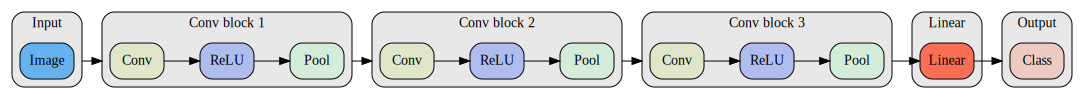

In [76]:
#hide
blocks  = ['Input', 'Conv block 1', 'Conv block 2', 'Conv block 3', 'Linear', 'Output']
layers = [['Image'], ['Conv','ReLU', 'Pool'], ['Conv', 'ReLU', 'Pool'], ['Conv','ReLU', 'Pool'], ['Linear'], ['Class']]
conns = ((blocks[0], blocks[1]),
         (blocks[1], blocks[2]),
         (blocks[2], blocks[3]),
         (blocks[3], blocks[4]),
         (blocks[4], blocks[5]),
        )
g = graph_items(seq_cluster(layers[0], blocks[0]),
                seq_cluster(layers[1], blocks[1]),
                seq_cluster(layers[2], blocks[2]),
                seq_cluster(layers[3], blocks[3]),
                seq_cluster(layers[4], blocks[4]),
                seq_cluster(layers[5], blocks[5]),
               )
g.add_items(*object_connections(conns))
g

In [77]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels=1, ks=3, out_channels=16, stride=1, padding=0, act_fn=nn.ReLU()):
        super().__init__()
        self.conv =  nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels, 
                               kernel_size=ks, 
                               stride=stride, padding=padding)
        
        self.act_fn = act_fn
        self.pool   = nn.MaxPool2d(kernel_size=ks-1)
    def forward(self, x):
        x = self.conv(x)
        x = self.act_fn(x)
        x = self.pool(x)
        return x
    
    
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvBlock(in_channels=1, 
                                     out_channels=16)
        
        self.conv_block2 = ConvBlock(in_channels=16, 
                                     out_channels=32)
        
        self.conv_block3 = ConvBlock(in_channels=32,
                                     out_channels=64)

        
        self.linear =  nn.Linear(64, 10)
            
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.linear(x.view(x.size(0), -1))
        return x

Let's take a look at the model summary

In [78]:
model = CNNModel().eval()
model

CNNModel(
  (conv_block1): ConvBlock(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (act_fn): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (act_fn): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (act_fn): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

Let's do a forward pass manually, step by step through the three convolutional blocks and the linear layer (all of which are now attributes of out model object `model`)

In [79]:
x, y = next(iter(valid_dl)) # get one batch from validation dataset

In [80]:
x.shape # this is the input

torch.Size([64, 1, 28, 28])

In [81]:
conv_block1_out = model.conv_block1(x)

In [82]:
conv_block1_out.shape # (batch, channels, pixels, pixels)

torch.Size([64, 16, 13, 13])

In [83]:
conv_block2_out = model.conv_block2(conv_block1_out)

In [84]:
conv_block2_out.shape # (batch, channels, pixels, pixels)

torch.Size([64, 32, 5, 5])

In [85]:
conv_block3_out = model.conv_block3(conv_block2_out)

In [86]:
conv_block3_out.shape

torch.Size([64, 64, 1, 1])

In [87]:
out = model.linear(conv_block3_out.view(64, -1))
out.shape # (batch, n_classes)

torch.Size([64, 10])

Now let's initialize the model (again) and train!

In [88]:
num_classes = 10
num_epochs = 5
learning_rate = 0.1

model = CNNModel()
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [89]:
model, losses = train_fit(model, loss_fn, train_dl, num_epochs, optimizer)

Epoch [1/5], Step [100/938], Loss: 1.9405
Epoch [1/5], Step [200/938], Loss: 1.5364
Epoch [1/5], Step [300/938], Loss: 0.4377
Epoch [1/5], Step [400/938], Loss: 0.3577
Epoch [1/5], Step [500/938], Loss: 0.2627
Epoch [1/5], Step [600/938], Loss: 0.1638
Epoch [1/5], Step [700/938], Loss: 0.2419
Epoch [1/5], Step [800/938], Loss: 0.1942
Epoch [1/5], Step [900/938], Loss: 0.1818
Epoch [2/5], Step [100/938], Loss: 0.1246
Epoch [2/5], Step [200/938], Loss: 0.2072
Epoch [2/5], Step [300/938], Loss: 0.0597
Epoch [2/5], Step [400/938], Loss: 0.1967
Epoch [2/5], Step [500/938], Loss: 0.0665
Epoch [2/5], Step [600/938], Loss: 0.1391
Epoch [2/5], Step [700/938], Loss: 0.0400
Epoch [2/5], Step [800/938], Loss: 0.1364
Epoch [2/5], Step [900/938], Loss: 0.0812
Epoch [3/5], Step [100/938], Loss: 0.0382
Epoch [3/5], Step [200/938], Loss: 0.0187
Epoch [3/5], Step [300/938], Loss: 0.1647
Epoch [3/5], Step [400/938], Loss: 0.0349
Epoch [3/5], Step [500/938], Loss: 0.0270
Epoch [3/5], Step [600/938], Loss:

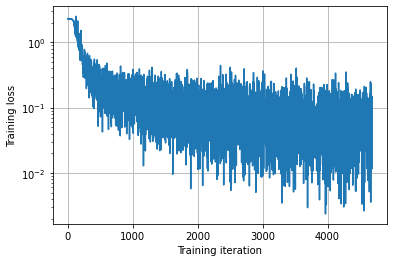

In [90]:
plt.plot(losses)
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.yscale('log')
plt.grid()

In [92]:
valid_fit(model, valid_dl)

Accuracy of the model on the 10000 test images: 97.45999908447266 %
